In [1]:
import itertools
import pickle
import copy 
import numpy as np
import torch
import matplotlib.pyplot as plt
from leela_interp import Lc0sight, LeelaBoard
from leela_interp.tools.attention import attention_attribution, top_k_attributions
from leela_interp.tools.patching import activation_patch

/media/victor/F8D25071D25035DA/Alingment/lela-interp/neelaplicationexperiment/leela-interp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
%cd ..

/media/victor/F8D25071D25035DA/Alingment/lela-interp/neelaplicationexperiment/leela-interp


/media/victor/F8D25071D25035DA/Alingment/lela-interp/neelaplicationexperiment/leela-interp/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Lc0sight("lc0.onnx", device=device)
with open("results/probing/all/0/target_probes.pkl", "rb") as f:
    target_probes = pickle.load(f)

Using device: cuda


In [4]:
with open("interesting_puzzles.pkl", "rb") as f:
    puzzles = pickle.load(f)
len(puzzles)


22517

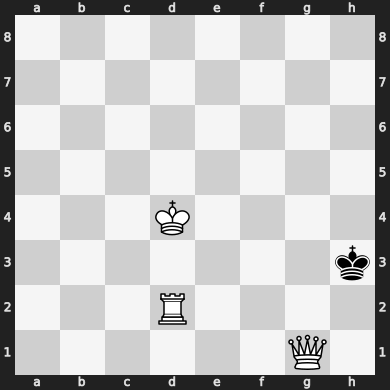

In [5]:

#puzzle = "8/7k/8/8/5R2/6R1/8/1K6"
#http://www.netreal.de/Forsyth-Edwards-Notation/index.php

puzzle ="8/8/8/8/3K4/7k/3R4/6Q1"
board = LeelaBoard.from_fen(puzzle)
board

In [6]:
puzzle = puzzles.iloc[483]
# LeelaBoard instances can also be created from FENs or in other ways, but always
# use from_puzzle if you want to create one from a puzzle from the lichess dataset.
board = LeelaBoard.from_puzzle(puzzle)

Leela solves this puzzle correctly:

In [7]:
model.pretty_play(board)

Ng6+: 57.87%
a4: 9.01%
Kh2: 8.27%
h4: 8.08%
Qd3: 3.91%
W: 28.72%, D: 49.91%, L: 21.37%


In [8]:
layer = 12
head =  12

# We're using nnsight to cache activations and do interventions. There's also an interface
# based directly on pytorch hooks if you prefer that, see Lc0Model.capturing().
with model.trace(board):
    attention = model.attention_scores(layer).output[0, head].save()
attention.shape

torch.Size([64, 64])

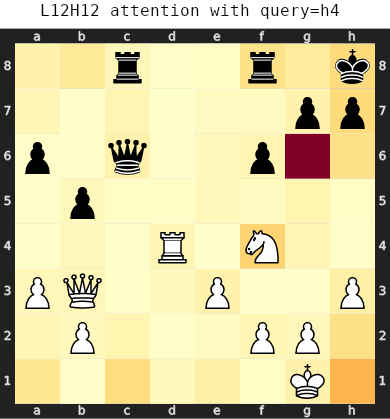

In [9]:
square = f"h4"
idx = board.sq2idx(square)
board.plot(attention[idx], caption=f"L{layer}H{head} attention with query={square}")

In [10]:
def target_probe_prediction(target_probes,first_move_target,layer = 12):
    if isinstance(first_move_target, str): 
        first_move_target_n=board.sq2idx(first_move_target)
    else:
        first_move_target_n=first_move_target
    with model.trace(board):
        residual_stream = model.residual_stream(layer).output.save()

    X = residual_stream
    Z = X[np.arange(len(X)), [first_move_target_n], :]
    return target_probes[layer].predict_proba(X, Z)

In [11]:
third_move_target= "h4"
third_move_target_n=board.sq2idx(third_move_target)

/media/victor/F8D25071D25035DA/Alingment/lela-interp/leela-interp/src/leela_interp/tools/probing.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z_pt = torch.tensor(Z, dtype=torch.float32, device=device)


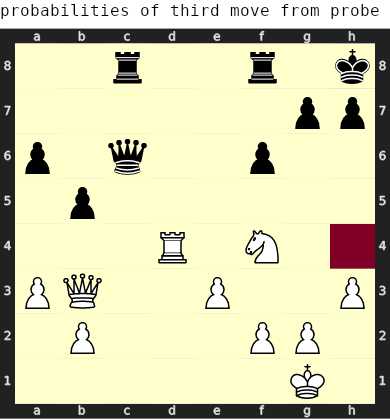

In [12]:
board.plot(target_probe_prediction(target_probes,"h4",layer=10)[0], caption="probabilities of third move from probe")

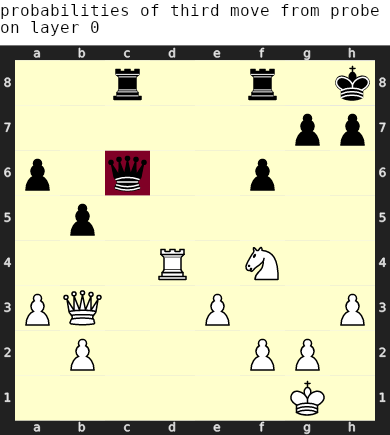

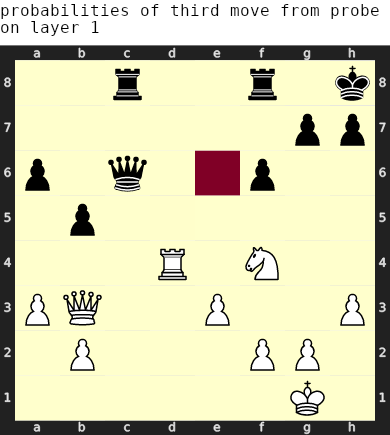

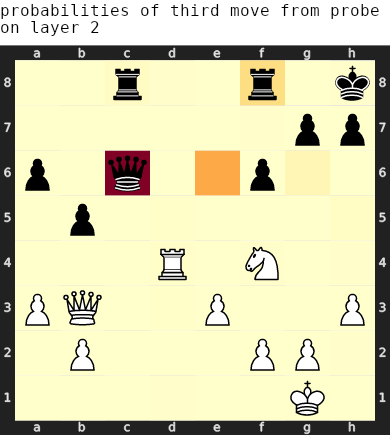

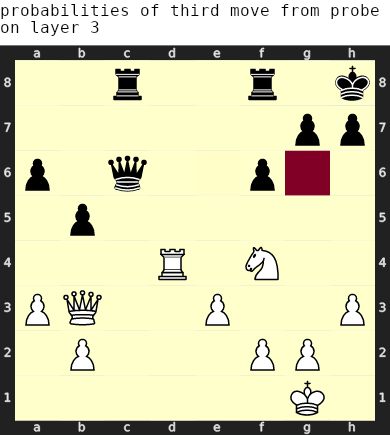

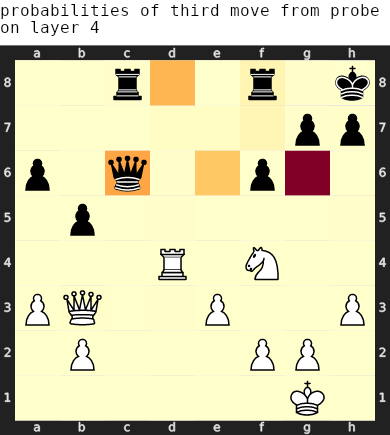

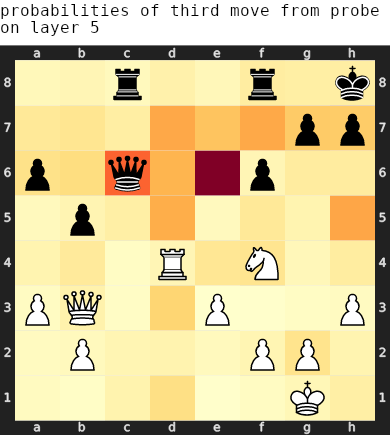

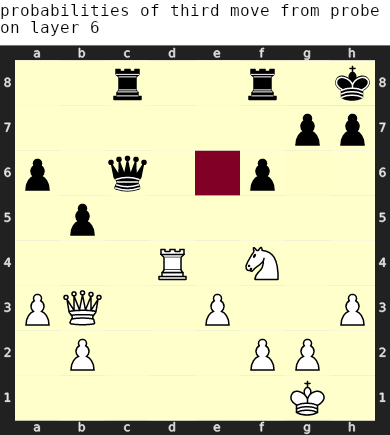

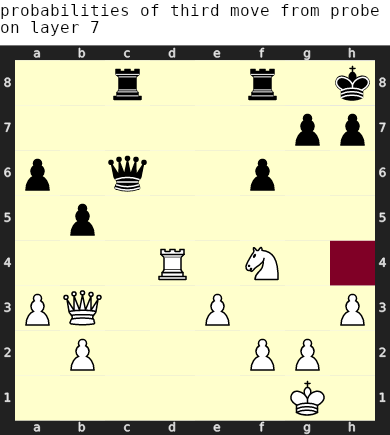

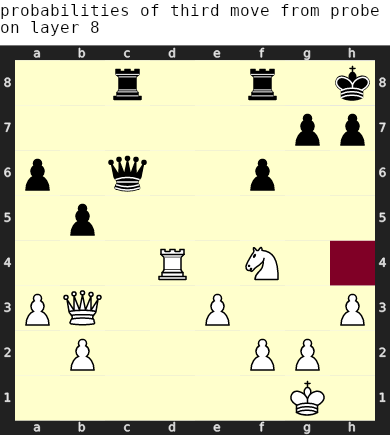

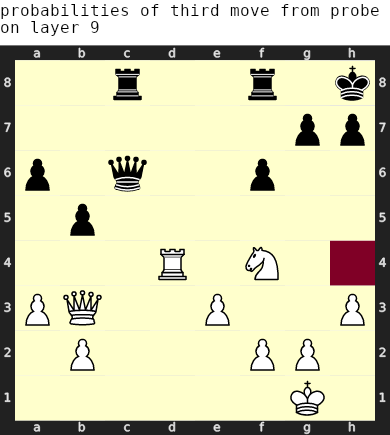

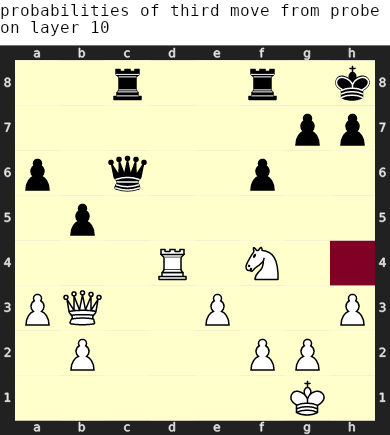

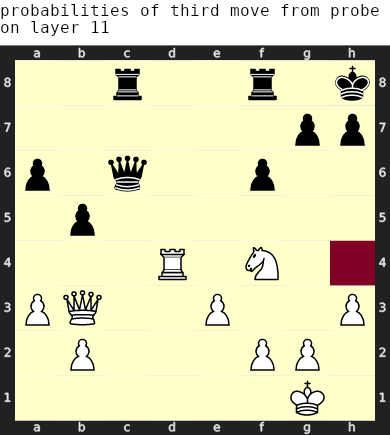

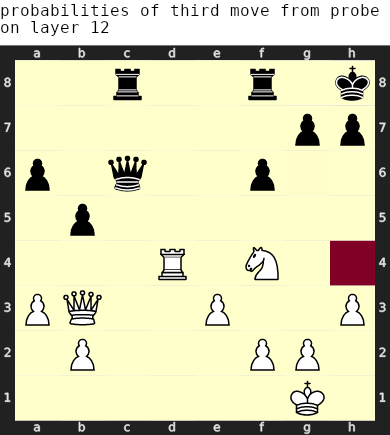

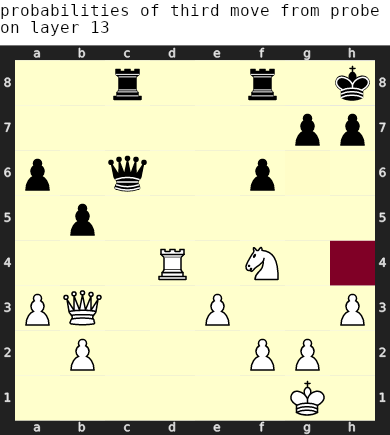

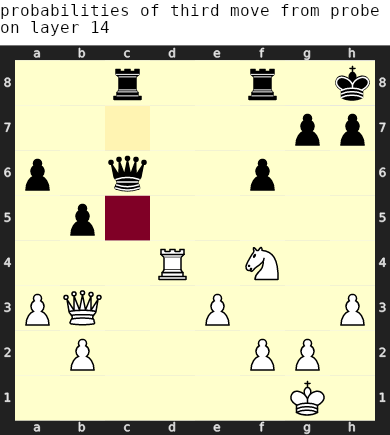

In [13]:
for layer in range(15):
   display( board.plot(target_probe_prediction(target_probes,"h4",layer=layer)[0], caption=f"probabilities of third move from probe on layer {layer}"))

# Probe from all positions fixed layer

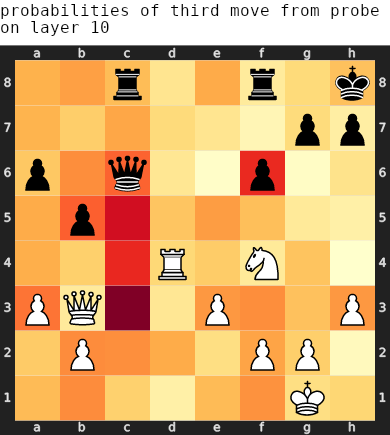

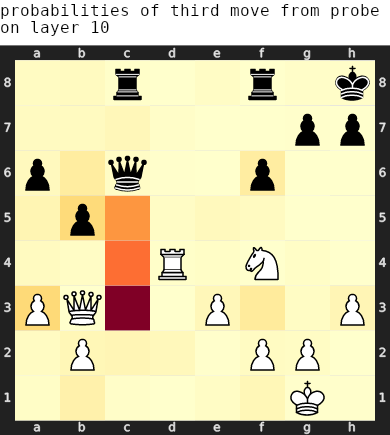

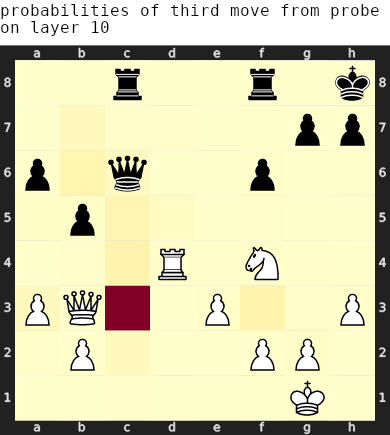

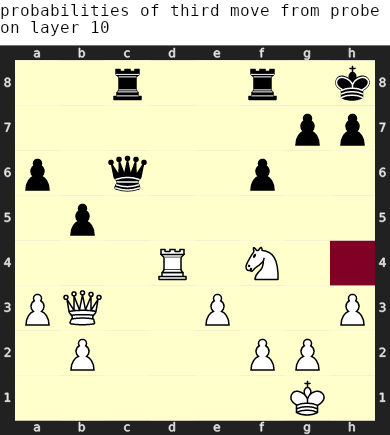

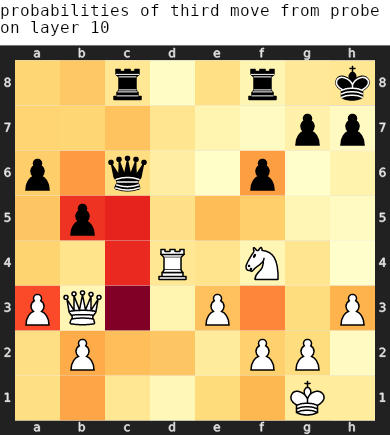

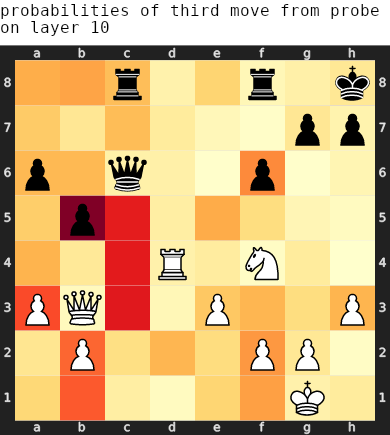

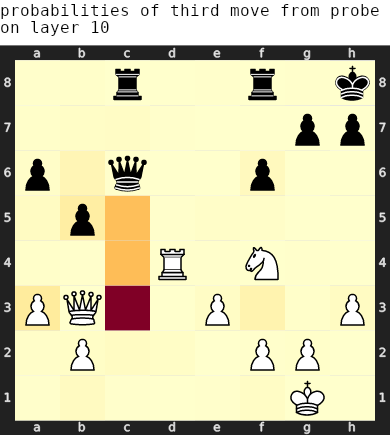

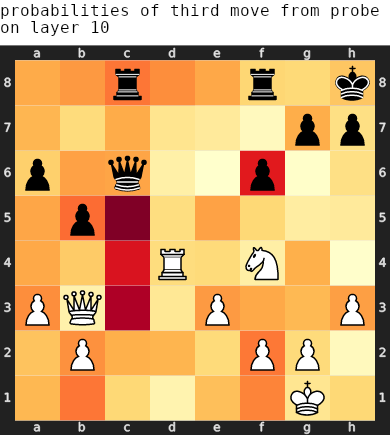

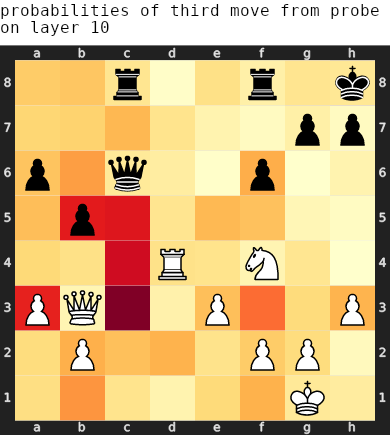

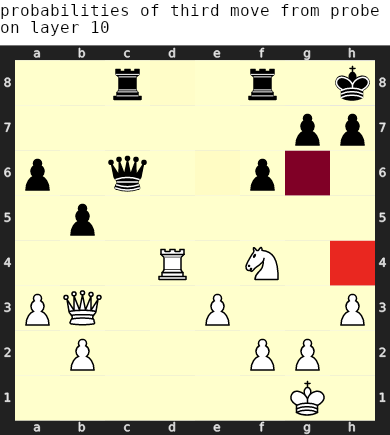

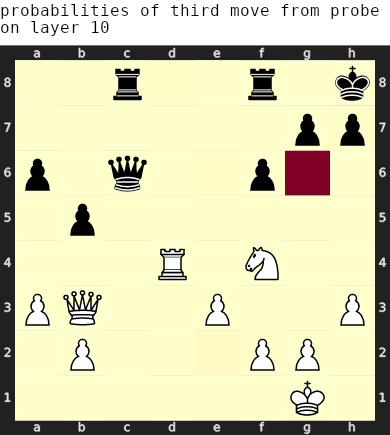

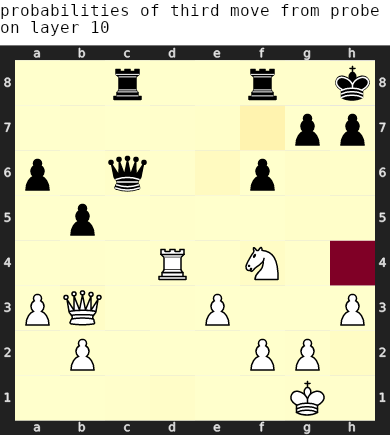

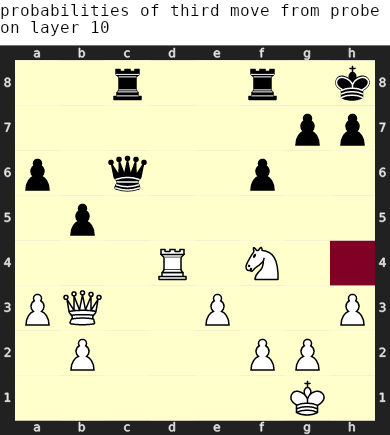

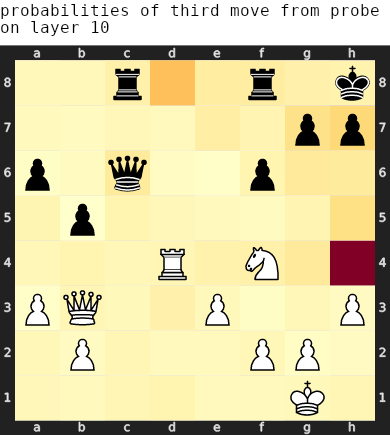

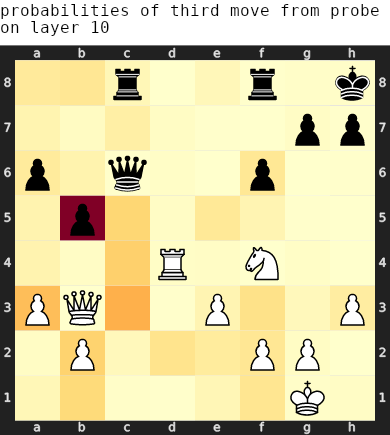

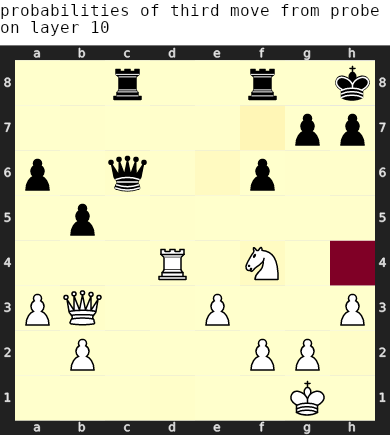

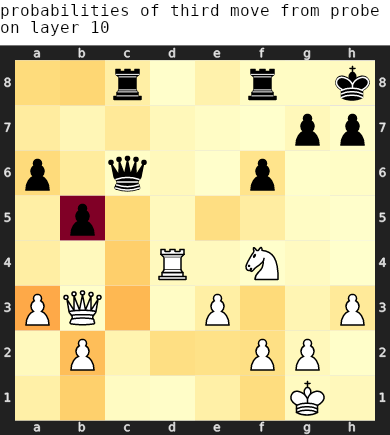

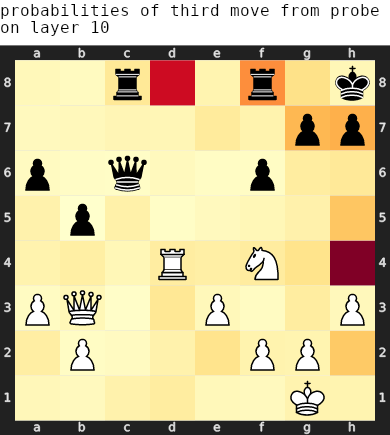

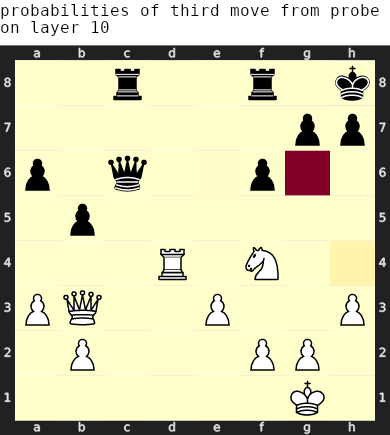

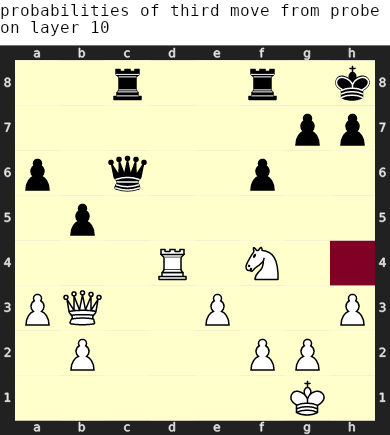

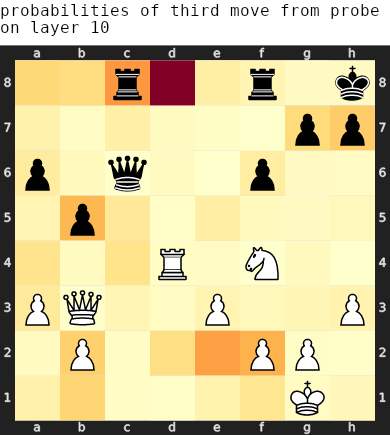

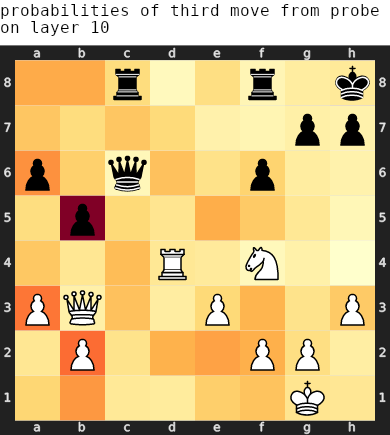

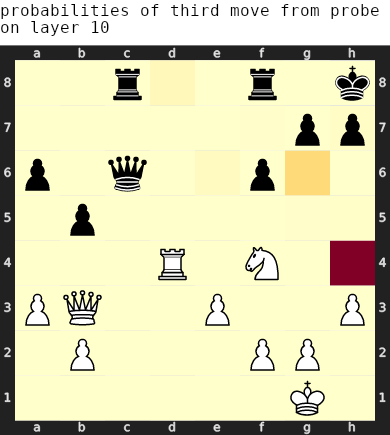

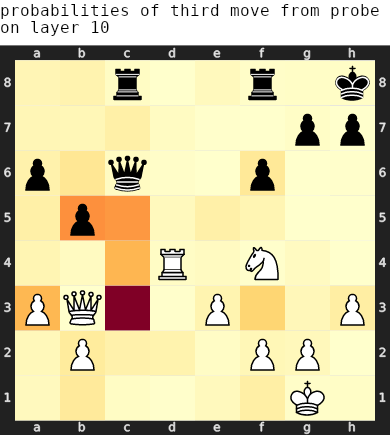

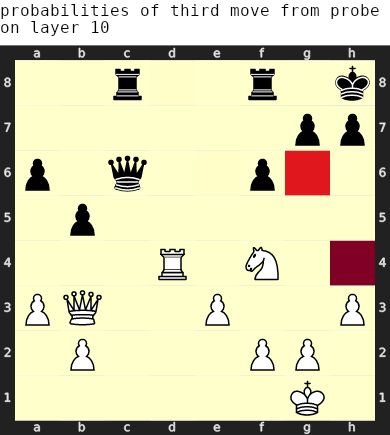

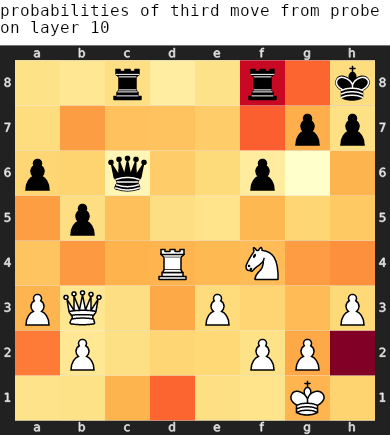

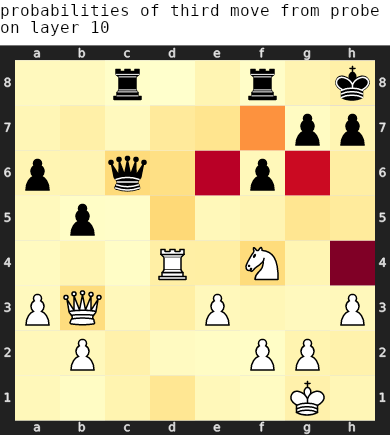

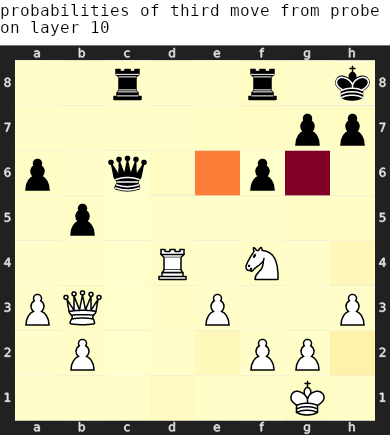

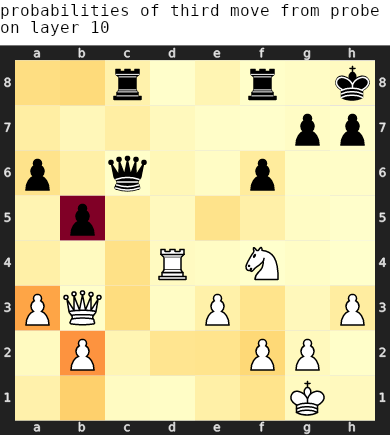

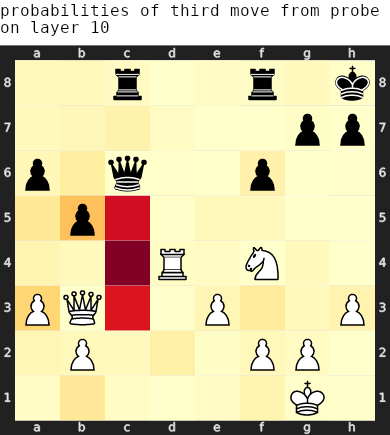

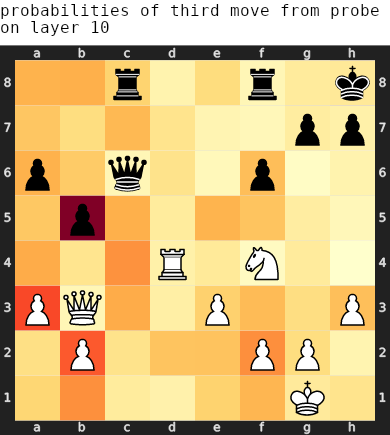

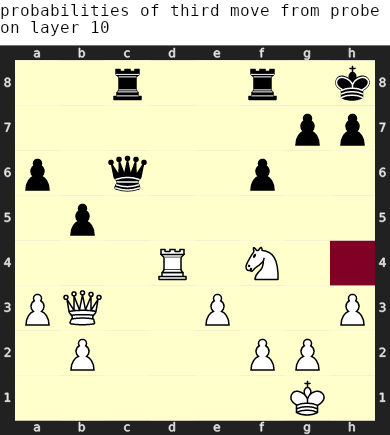

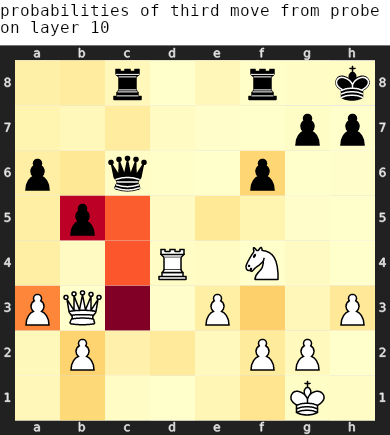

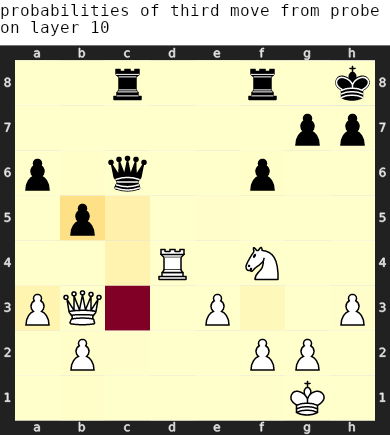

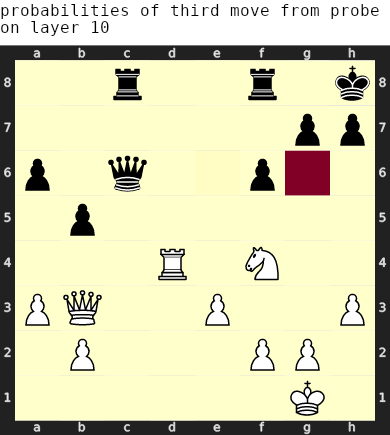

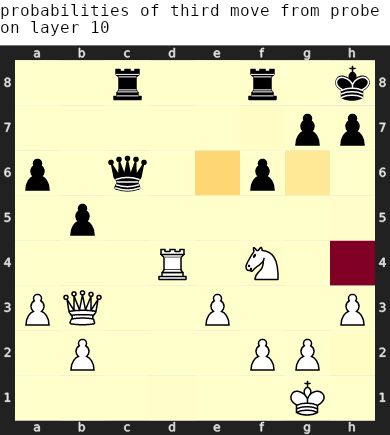

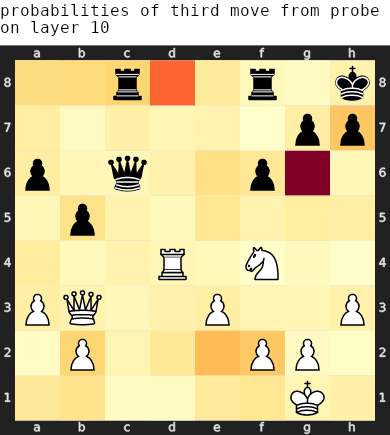

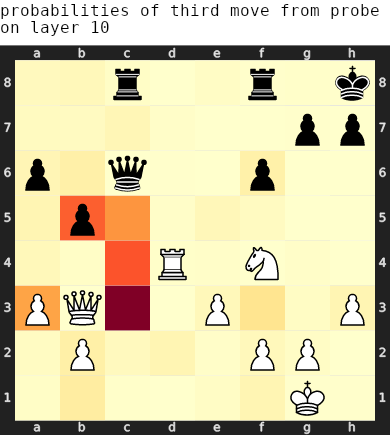

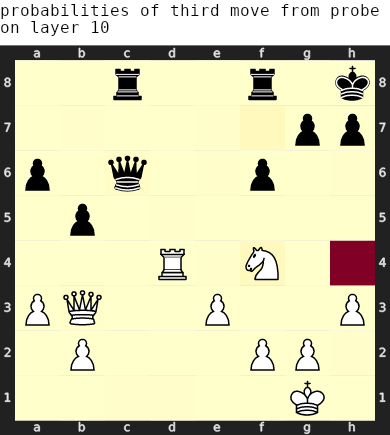

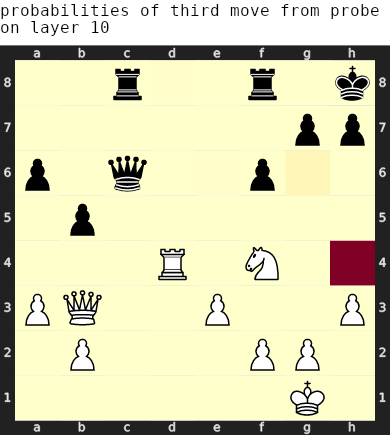

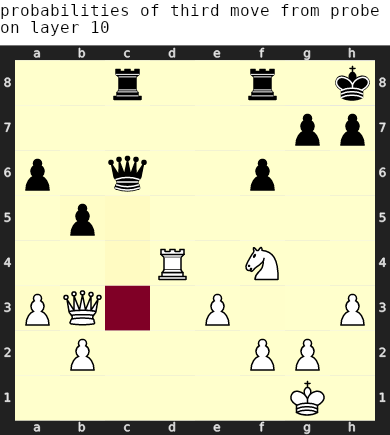

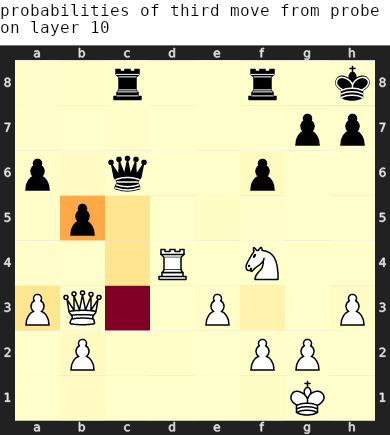

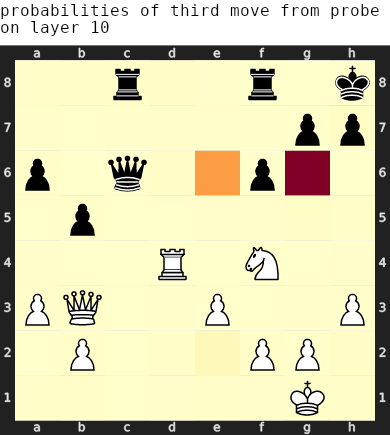

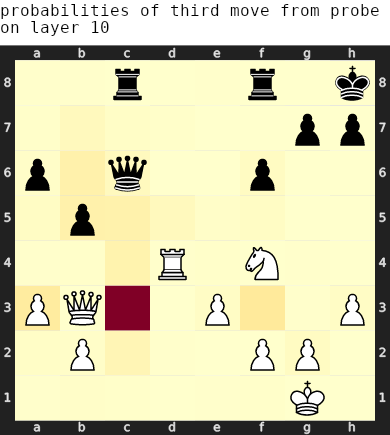

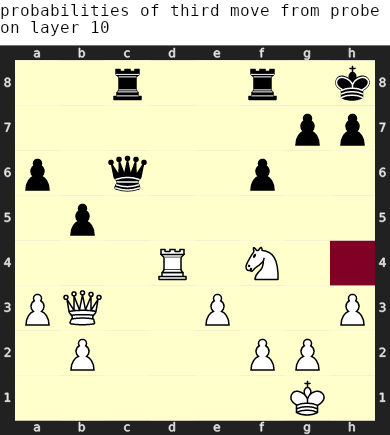

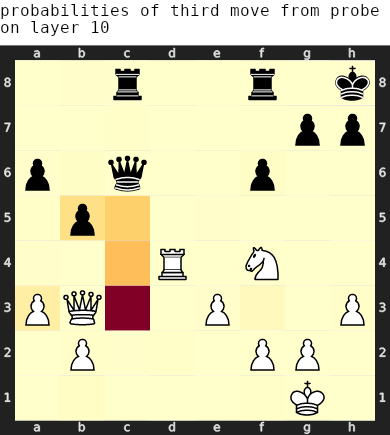

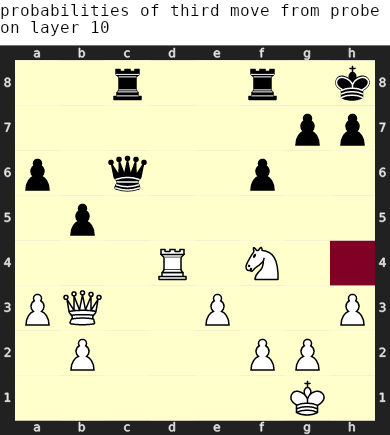

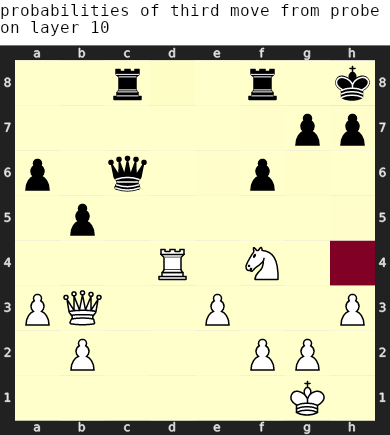

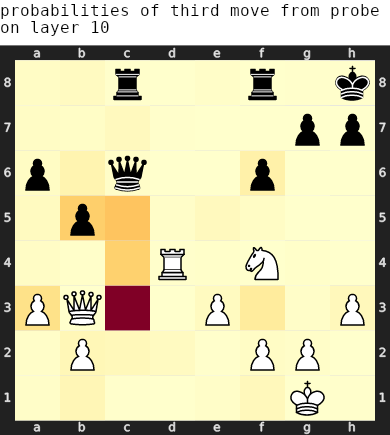

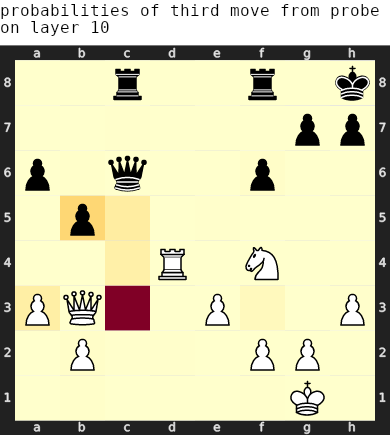

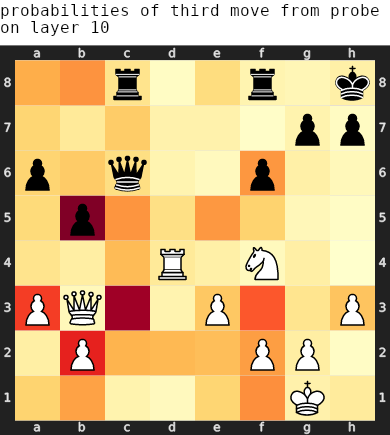

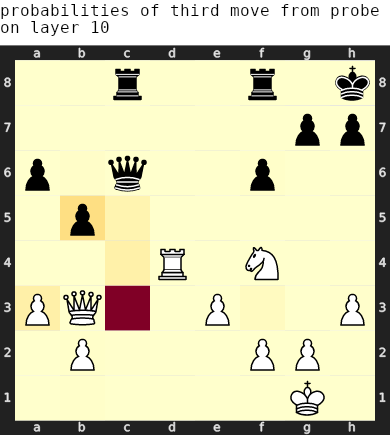

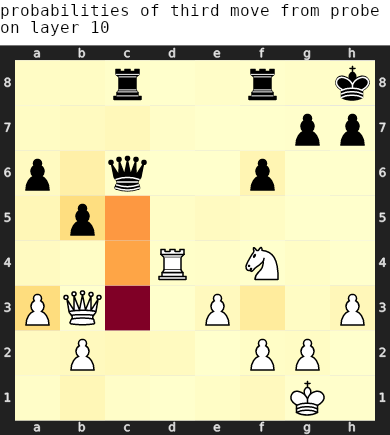

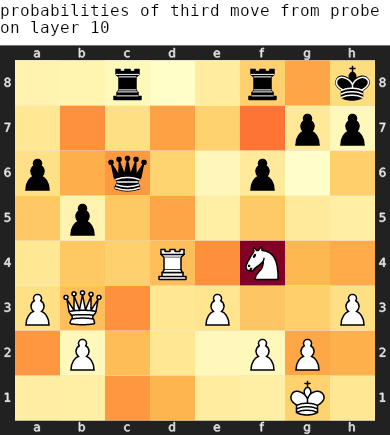

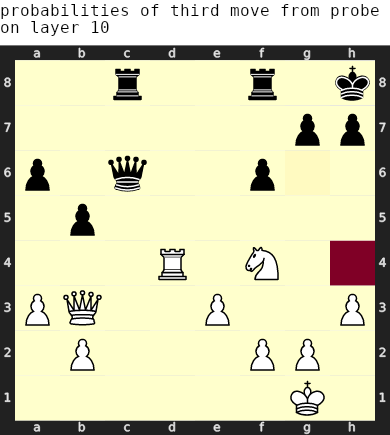

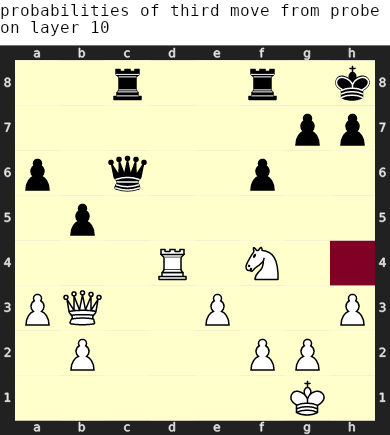

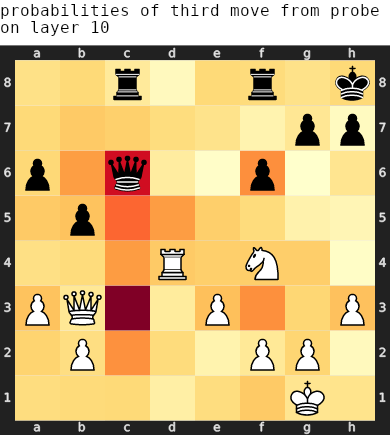

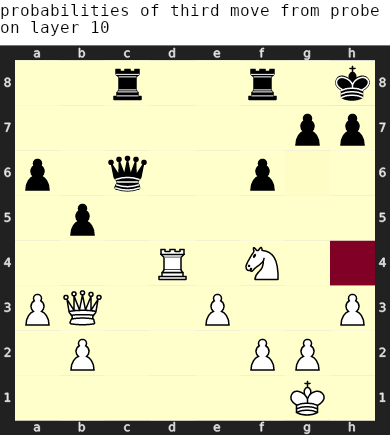

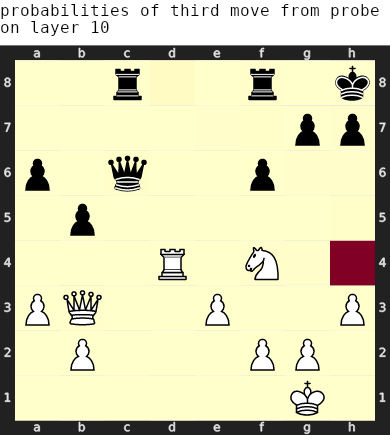

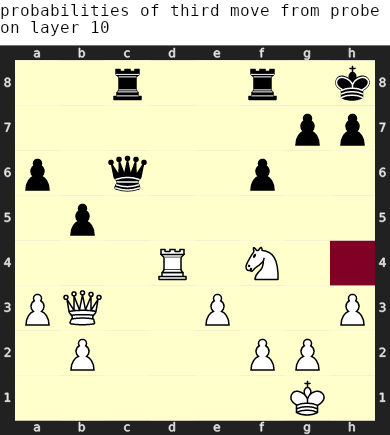

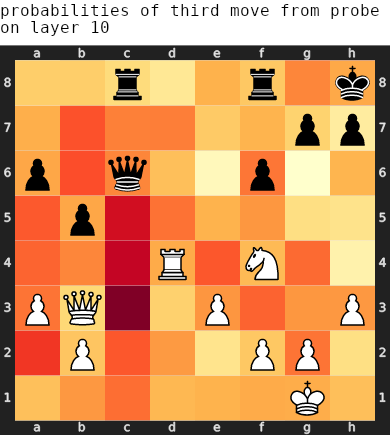

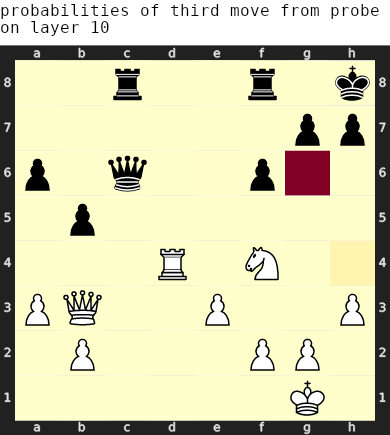

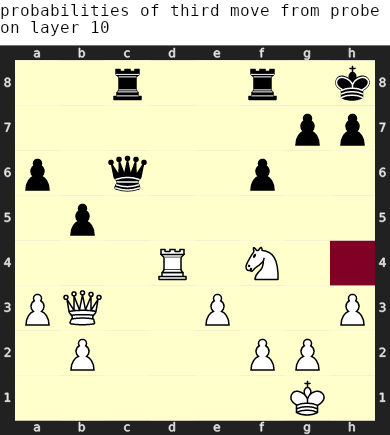

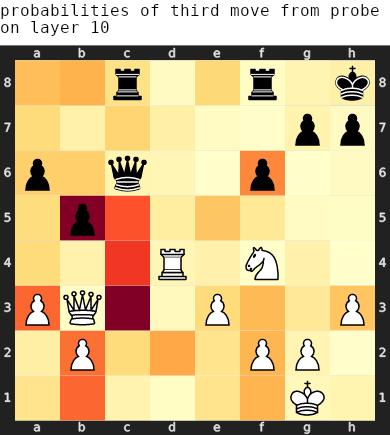

In [14]:
layer=10
for i in range(64):
    display( board.plot(target_probe_prediction(target_probes,i,layer=layer)[0], caption=f"probabilities of third move from probe on layer {layer}"))

# Systematic testing